# Segmentez des clients d'un site e-commerce
**(Partie 1 - Traitement des données, Exploration)**

**Il s´agit ici de fournir une segmentation client aux équipes d´e-commerce de la société OLIST.**

Dans un premier temps, on rassemble les données disponibles. Après une exploration et un prétraitement, elles sont sauvegardées pour être utilisées dans le second notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mso

## Lecture des fichiers

In [2]:
files = os.listdir("donnee/archive")

In [3]:
for name in files:
    nom_fichier = "donnee/archive"+"/"+name
    data = pd.read_csv(nom_fichier)
    chaine = 'data_' + name[:-4] 
    print("\nNom de Fichier: ",chaine)
    exec(chaine + ' = data')
    print("Colonne: ",data.columns.tolist())
    print("Taille: ", data.shape)


Nom de Fichier:  data_olist_customers_dataset
Colonne:  ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
Taille:  (99441, 5)

Nom de Fichier:  data_olist_geolocation_dataset
Colonne:  ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
Taille:  (1000163, 5)

Nom de Fichier:  data_olist_orders_dataset
Colonne:  ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
Taille:  (99441, 8)

Nom de Fichier:  data_olist_order_items_dataset
Colonne:  ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
Taille:  (112650, 7)

Nom de Fichier:  data_olist_order_payments_dataset
Colonne:  ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
Taille:  (103886, 5)

Nom

## Traitement du jeu de données

Fusion des fichiers

In [4]:
## Combination: data_olist_order_payments_dataset et data_olist_order_items_dataset
df_order = pd.merge(data_olist_order_payments_dataset,data_olist_order_items_dataset,on='order_id',how='inner')

In [5]:
## Combination: data_olist_customers_dataset et data_olist_orders_dataset
df_customers = pd.merge(data_olist_customers_dataset,data_olist_orders_dataset,on='customer_id')
df = pd.merge(df_order,df_customers,on='order_id')

In [6]:
## Combination: data_olist_products_dataset et data_olist_order_reviews_dataset 
df = pd.merge(df,data_olist_products_dataset,on='product_id',how='left')
df = pd.merge(df,data_olist_order_reviews_dataset,on='order_id',how='left')

Selection de colonnes

In [7]:
list_columns = df.columns.tolist()

## uncommented features are selected
list_columns_select = [
     'customer_id',
     'customer_unique_id',
     ##'customer_zip_code_prefix',
     'customer_city',
     ##'customer_state',
     'order_id',
     ##'order_status',
     'order_purchase_timestamp',
     ##'order_approved_at',
     ##'order_delivered_carrier_date',
     'order_delivered_customer_date',
     'order_estimated_delivery_date',
     ##'payment_sequential',
     ##'payment_type',
     ##'payment_installments',
     ##'payment_value',
     'order_item_id',
     'product_id',
     ##'seller_id',
     ##'shipping_limit_date',
     'price',
     'freight_value',
     'product_category_name',
     ##'product_name_lenght',
     ##'product_description_lenght',
     'product_photos_qty',
     ##'product_weight_g',
     ##'product_length_cm',
     ##'product_height_cm',
     ##'product_width_cm',
     ##'review_id',
     'review_score',
     ##'review_comment_title',
     'review_comment_message',
     ##'review_creation_date',
     ##'review_answer_timestamp'
               ]

In [8]:
list_columns_remove = list(set(list_columns)-set(list_columns_select))
df.drop(columns=list_columns_remove,inplace=True)

## Transformation et création de variables

**Imputation**

In [9]:
df['product_category_name'].fillna('unknown',inplace=True)
df['product_photos_qty'].fillna(0,inplace=True);

**Transformation des dates**

In [10]:
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

## imputation : switching real delay with estimated delay
masque = df['order_delivered_customer_date'].isna()
df.loc[masque, 'order_delivered_customer_date'] = df.loc[masque, 'order_estimated_delivery_date']

## adding month and year
df['order_purchase_timestamp_M'] = df['order_purchase_timestamp'].apply(lambda x:x.month)
df['order_purchase_timestamp_Y'] = df['order_purchase_timestamp'].apply(lambda x:x.year)

In [11]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

-  Durée de livraison

In [12]:
## real delay
delay = df['order_estimated_delivery_date']-df['order_purchase_timestamp']
df['order_delivery_delay_estimated'] = delay.apply(lambda x:x.days)

In [13]:
## estimated delay
df['order_delivery_delay'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp'])\
.apply(lambda x:x.days)

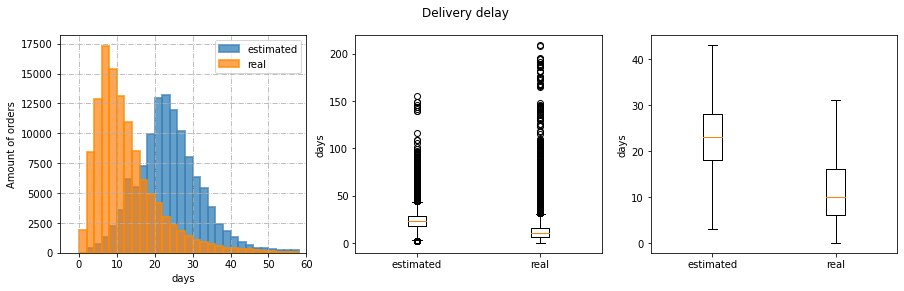

In [14]:
## real delay < estimated delay
fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.suptitle('Delivery delay')

ax[0].hist(df['order_delivery_delay_estimated'],
         alpha=0.7,edgecolor='steelblue',linewidth=2,label='estimated',bins=range(0,60,2))
ax[0].hist(df['order_delivery_delay'],
         alpha=0.7,edgecolor='darkorange',linewidth=2,label='real',bins=range(0,60,2))

ax[0].legend()
ax[0].set_xlabel('days')
ax[0].set_xlim([-5,60])
ax[0].grid(linestyle='-.')
ax[0].set_ylabel('Amount of orders')

column_list = ['order_delivery_delay_estimated','order_delivery_delay']
ax[1].boxplot(df[column_list], labels=['estimated','real']);
ax[1].set_ylabel('days')
ax[2].boxplot(df[column_list],showfliers=False, labels=['estimated','real']);
ax[2].set_ylabel('days');

Le délai réel est inférieur au délai estimé.

In [15]:
## delivery delay : less than 16 days for 75% of the orders
df['order_delivery_delay'].describe()

count    118315.000000
mean         12.300562
std           9.670339
min           0.000000
25%           6.000000
50%          10.000000
75%          16.000000
max         209.000000
Name: order_delivery_delay, dtype: float64

In [16]:
## less than 60 days for 99.7% of the orders
df['order_delivery_delay'].quantile(0.997)

60.0

In [17]:
## 19 orders with 0 delay
df[df['order_delivery_delay']==0].shape[0]

19

In [18]:
df[df['order_delivery_delay']==df['order_delivery_delay'].max()]['review_comment_message'].to_list()

['uma falta de respeito com o consumidor , estou muito decepcionado .']

**Prix par commande et frais de transport par commande**

In [19]:
df_test = df.drop_duplicates(subset=['order_id','order_item_id']).copy()

## order
price = df_test.groupby('order_id')['price'].sum().reset_index()
price = price.rename(columns={'price':'price_order'});

## freight value
freight = df_test.groupby('order_id')['freight_value'].sum().reset_index()
freight = freight.rename(columns={'freight_value':'freight_value_order'})

## number of items
item_number = df_test.groupby('order_id')['order_item_id'].count().reset_index()
item_number = item_number.rename(columns={'order_item_id':'order_item_id_number'})

df = pd.merge(df, pd.merge(price, pd.merge(freight,item_number,on='order_id')),on='order_id')

Le nombre d´article par commande varie de 1 à 21.  
90% des commandes sont composées d´un seul article.

In [20]:
df_test.groupby('order_id')['order_item_id'].count().describe()

count    98665.000000
mean         1.141712
std          0.538423
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: order_item_id, dtype: float64

In [21]:
df_test.groupby('order_id')['order_item_id'].count().quantile(0.90)

1.0

In [22]:
## feature total_price_order.
df['total_price_order'] = df['price_order'] + df['freight_value_order']

In [23]:
## feature monetary_value.

df.drop_duplicates('customer_id',inplace=True)
monetary_value = df.groupby('customer_unique_id')['total_price_order'].mean().reset_index()
monetary_value = monetary_value.rename(columns={'total_price_order':'monetary_value'})

df = pd.merge(df,monetary_value,on='customer_unique_id',how='left')

Conversion real -> euros

In [24]:
## conversion real -> euros
columns_list = ['price_order', 'freight_value_order', 'total_price_order', 'monetary_value']
for column in columns_list:
    df[column] *= 0.159

Passage au log des prix 

In [25]:
# ## function np.log
# columns_list = ['price_order', 'freight_value_order', 'total_price_order', 'monetary_value']
# for column in columns_list:
#     df[column] = (df[column]+1).apply(np.log)

Traduction

In [26]:
## translation of product category name
for produit in data_product_category_name_translation['product_category_name'].to_list():
    masque = df['product_category_name'] == produit
    masque_translation = data_product_category_name_translation['product_category_name'] == produit
    df.loc[masque,'product_category_name'] = data_product_category_name_translation.loc[masque_translation,'product_category_name_english'].iat[0]

Second tri

In [27]:
list_columns = df.columns.tolist()
list_columns_select= [
     ##'order_id',
     ##'order_item_id',
     ##'product_id',
     ##'price',
     ##'freight_value',
     'customer_id',
     'customer_unique_id',
     'customer_city',
     'order_purchase_timestamp',
     ##'order_delivered_customer_date',
     ##'order_estimated_delivery_date',
     'product_category_name',
     'product_photos_qty',
     'review_score',
     'order_purchase_timestamp_M',
     'order_purchase_timestamp_Y',
     ##'order_delivery_delay_estimated',
     'order_delivery_delay',
     'price_order',
     'freight_value_order',
     'order_item_id_number',
     'review_comment_message',
     'total_price_order',
     'monetary_value' 
]
list_columns_remove = list(set(list_columns)-set(list_columns_select))
df.drop(columns=list_columns_remove,inplace=True)

## Exploration 

Fréquence

3% des clients enregistrés effectuent plus de un achat

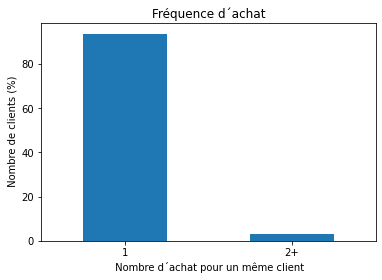

In [28]:
## frequency graph

var = df['customer_unique_id'].value_counts()

b = []
for ind in range(len(var.unique())):
    a = var.unique()[ind]
    b.append( (var==a).sum()*100/df.shape[0] )

bar_1y = b[-1]

bar_2y = sum(b[-2:0:-1])

pd.DataFrame([bar_1y,bar_2y],index=['1','2+']).plot(kind='bar',legend=None)

plt.title('Fréquence d´achat')
plt.ylabel(' Nombre de clients (%)')
plt.xlabel(' Nombre d´achat pour un même client')
plt.xticks(rotation=0)
plt.rcParams.update({'font.size': 12})

**Total price order**

**La valeur la plus fréquente se situe autour de ~10 euros**  
**80 % des commandes ont une valeur de moins de 100 euros, 99 % des commandes ont une valeur de moins de 600 euros.**

In [29]:
df['total_price_order'].describe()

count    98665.000000
mean        25.531872
std         35.054284
min          1.524810
25%          9.854820
50%         16.741110
75%         28.122330
max       2172.588720
Name: total_price_order, dtype: float64

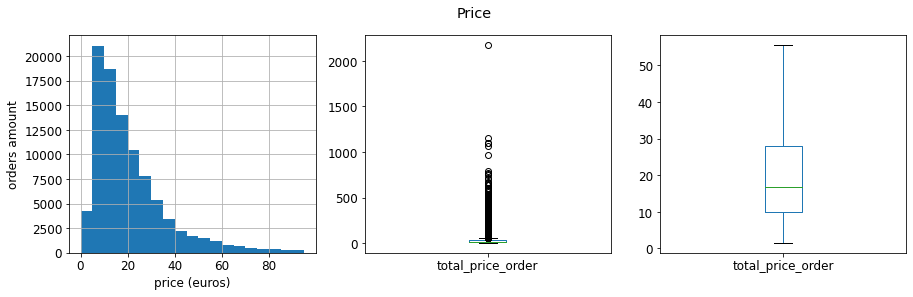

In [30]:
## total_price_order graph 
plt.figure(figsize=(15,4))
plt.suptitle('Price')
plt.subplot(131)
df[df['total_price_order']<100]['total_price_order'].hist(bins=range(0,100,5))
plt.ylabel('orders amount')
plt.xlabel('price (euros)')

plt.subplot(133)
df['total_price_order'].plot(kind='box',showfliers=False)

plt.subplot(132)
df['total_price_order'].plot(kind='box');

In [31]:
df.loc[df['total_price_order'] == df['total_price_order'].max(),'order_purchase_timestamp':'monetary_value']

,order_purchase_timestamp,product_category_name,product_photos_qty,review_score,review_comment_message,order_purchase_timestamp_M,order_purchase_timestamp_Y,order_delivery_delay,price_order,freight_value_order,order_item_id_number,total_price_order,monetary_value
50323,2017-09-29 15:24:52,fixed_telephony,3.0,1,"Peço por favor verificar a entrega do pedido, ...",9,2017,18,2136.96,35.62872,8,2172.58872,2172.58872


In [32]:
## outlier max
masque = df['total_price_order'] == df['total_price_order'].max()
df.loc[masque, 'review_comment_message'].to_list()

['Peço por favor verificar a entrega do pedido, pois não recebemos.']

In [33]:
## total sales volume 
volume = df.groupby('product_category_name')['total_price_order'].sum().sum()

In [34]:
## ~80% of orders less than 100 euros, 99% less than 600 euros
round(df[df['total_price_order']<100]['total_price_order'].sum()/volume*100)

80

### Représentation graphique

-  Variable catégorie de produit

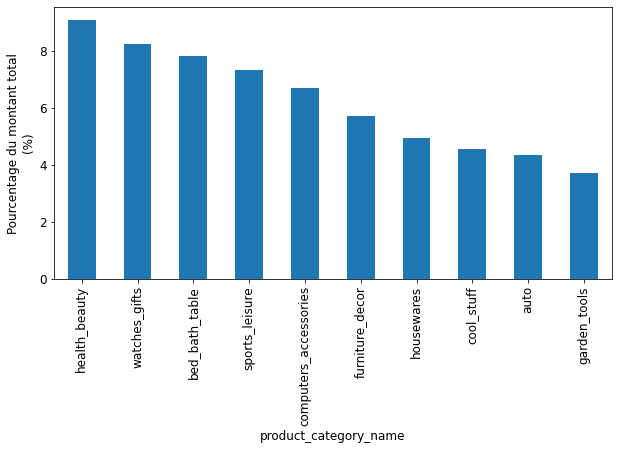

In [35]:
## product category name graph
prix_categorie = df.groupby('product_category_name')['total_price_order'].sum()
prix_categorie_p100 = prix_categorie/volume*100

plt.figure(figsize=(10, 5))
prix_categorie_p100.sort_values(ascending=False)[:10].plot(kind='bar')
plt.ylabel('Pourcentage du montant total\n(%)');

-  Variable nombre de photos

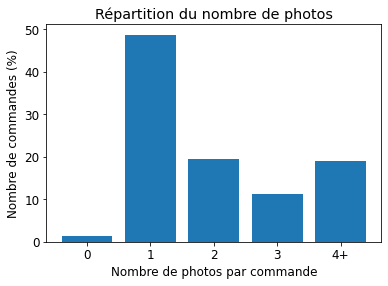

In [36]:
## photos quantity
df['product_photos_qty'] = pd.cut(df['product_photos_qty'],
                                      bins=[-1,0,1,2,3,20],
                                      labels=['0','1','2','3','4+'])

ind_x = ['0','1','2','3','4+']
height_y = df['product_photos_qty'].value_counts().loc[ind_x]*100/df['product_photos_qty'].value_counts().sum()

plt.bar(ind_x, height_y)
plt.title('Répartition du nombre de photos');
plt.xlabel('Nombre de photos par commande')
plt.ylabel('Nombre de commandes (%)');

In [37]:
## numerical and categorical values
X_num = df.loc[:,(df.dtypes=='float64') | (df.dtypes=='int64')]
X_object = df.loc[:,df.dtypes=='object']

In [38]:
X_num.columns

Index(['review_score', 'order_purchase_timestamp_M',
       'order_purchase_timestamp_Y', 'order_delivery_delay', 'price_order',
       'freight_value_order', 'order_item_id_number', 'total_price_order',
       'monetary_value'],
      dtype='object')

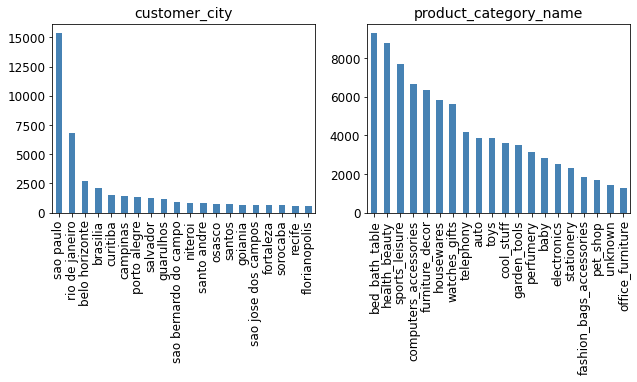

In [39]:
## categorical values histograms
X= X_object.copy()
fig = plt.figure(figsize=(16, 16))
ind=0
for feat_idx in range(2,X.shape[1]-1):
    ind += 1
    ax = fig.add_subplot(4,3, ind )
    X.iloc[:, feat_idx].value_counts().iloc[:20].plot(kind="bar",color='steelblue', edgecolor='none')
    ax.set_title(X.columns[feat_idx], fontsize=14)


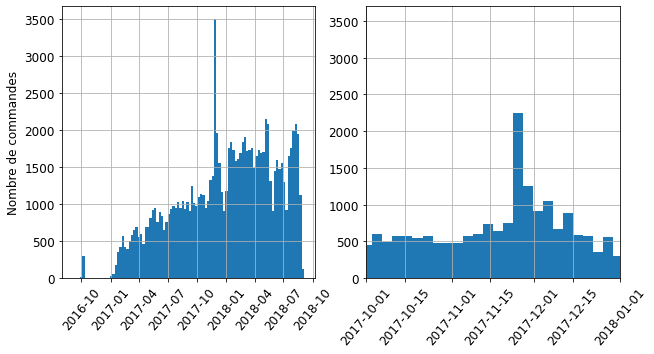

In [40]:
## histogram, time purchase range
plt.figure(figsize=(10, 5))

plt.subplot(121)
df['order_purchase_timestamp'].hist(bins=100)
plt.xticks(rotation=50);
plt.ylabel('Nombre de commandes')

plt.subplot(122)
df['order_purchase_timestamp'].hist(bins=200)
plt.xticks(rotation=50);
plt.axis([pd.Timestamp('2017-10'),pd.Timestamp('2018-01'),0,3700]);

Outliers

In [41]:
df.shape

(98665, 16)

In [42]:
df = df[df['total_price_order']<600].copy()

In [43]:
df = df[df['order_delivery_delay']<60].copy()

In [44]:
df.shape

(98316, 16)

## Enregistrement des données

In [45]:
mon_fichier = 'donnee/olist_log.csv'
df.to_csv(mon_fichier,index=False)

In [46]:
df.shape

(98316, 16)

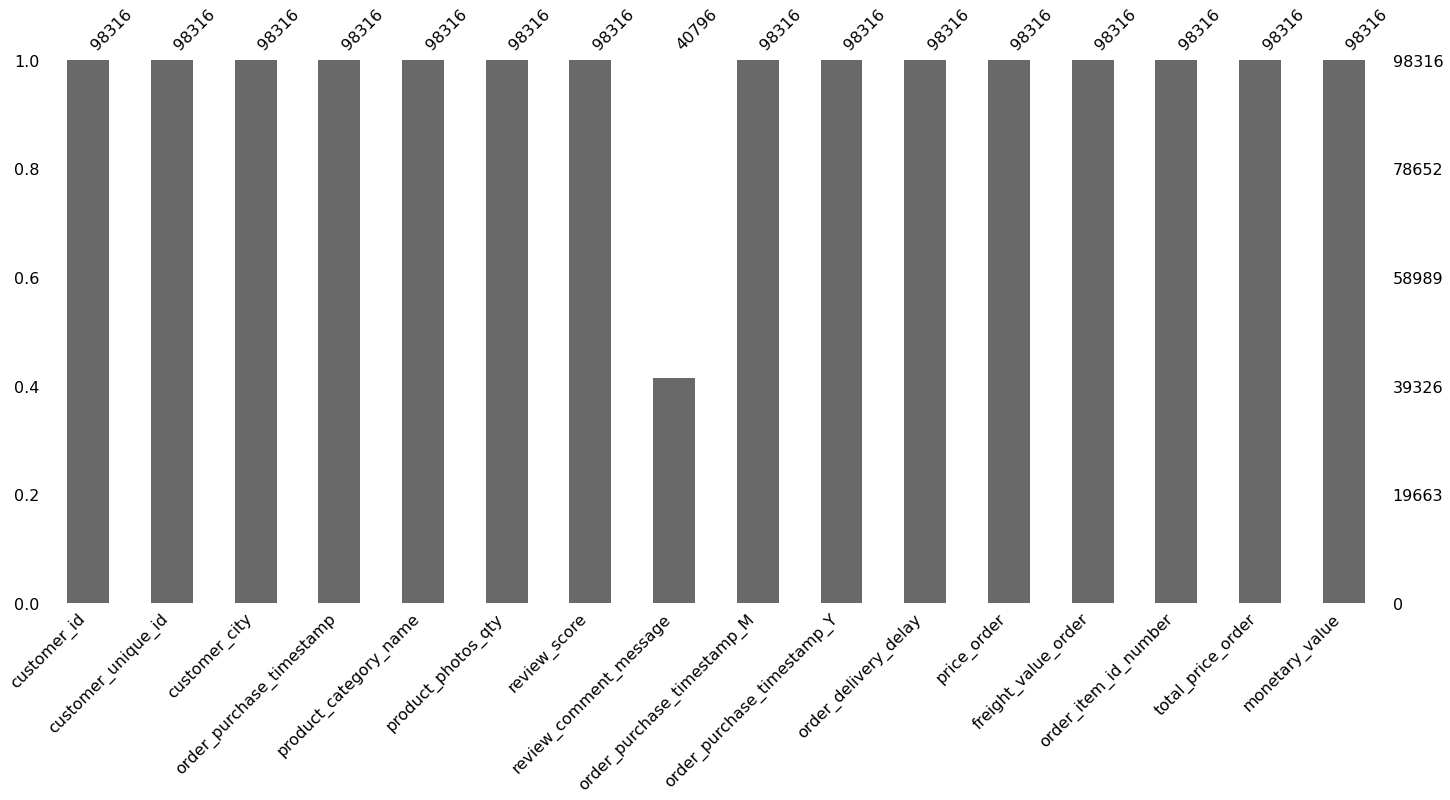

In [47]:
## missing values
mso.bar(df);